原文链接 https://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/download/12195/12023

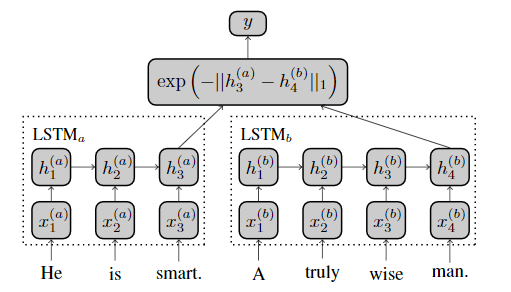

模型思路很简单，使用LSTM学习到的Hidden state，对不同句子求L1 norm，即求Manhattan distance

模型设计的原因：
- 简单结构而不是更深更复杂的网络，使模型将学习内容更好的关注在Hidden state所隐含的semantic information的差异（论文中的解释）
- 使用L1 norm作为相似度度量而不是L2 norm的理由：
    - L2 norm在A句和B句语义相关性很差时（independent），L2 norm的BP会出现vanishing gradient。整体的优化空间会出现一个平坦的梯度范围（called ‘undesirable plateaus ’）。
    - 实验表明，L1 norm相对于其他cosine similarity之类，表现稍微好一些（在该论文的问题环境下）。

实验结果：（反正就是说（chui）模型好）
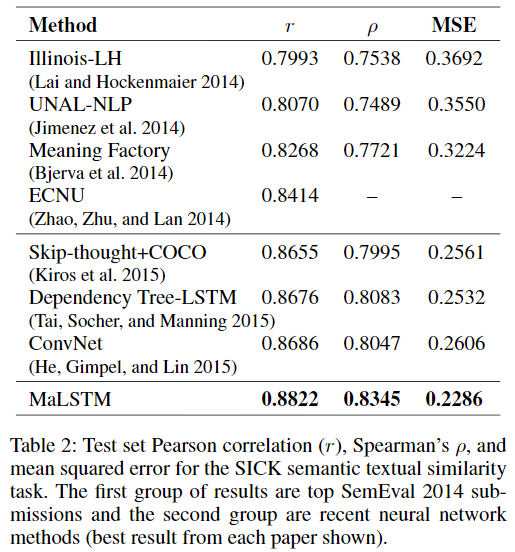

指标一：Pearson's correlation（接近1，更好）
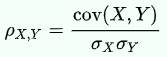

指标二：Spearman's rank correlation coefficient（接近1，更好）  
将样本转化为等级变量之后的相关性计算方法：

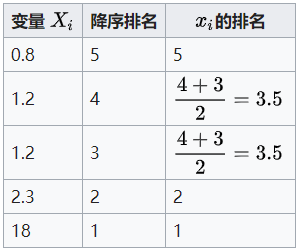

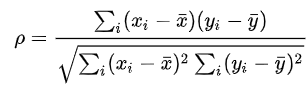

训练结果的Hidden state在不同维度上的可视化，是有一定解释能力的
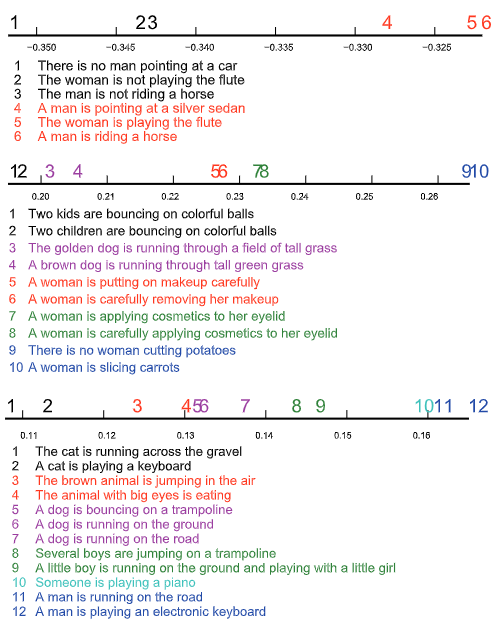

### Keras实现

data: kaggle competitions download -c quora-question-pairs

In [3]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda, Dropout
import keras.backend as K
from keras.optimizers import Adam
from keras import regularizers

import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import re
from tqdm import tqdm
import pickle

#### 训练集和测试集

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(len(train_df), len(test_df))
train_df.head()

#### 文本预处理

In [ ]:
stops = set(stopwords.words('english'))

In [ ]:
def preprocess(text):
    # input: 'Hello are you ok?'
    # output: ['Hello', 'are', 'you', 'ok', '?']
    text = str(text)
    text = text.lower()
    
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)  # 去掉其他符号
    text = re.sub(r"what's", "what is ", text)           # 缩写
    text = re.sub(r"\'s", " is ", text)                  # 缩写   
    text = re.sub(r"\'ve", " have ", text)               # 缩写
    text = re.sub(r"can't", "cannot ", text)             # 缩写
    text = re.sub(r"n't", " not ", text)                 # 缩写
    text = re.sub(r"i'm", "i am ", text)                 # 缩写
    text = re.sub(r"\'re", " are ", text)                # 缩写
    text = re.sub(r"\'d", " would ", text)               # 缩写
    text = re.sub(r"\'ll", " will ", text)               # 缩写
    text = re.sub(r",", " ", text)                       # 去除逗号
    text = re.sub(r"\.", " . ", text)                      # 保留句号
    text = re.sub(r"!", " ! ", text)                     # 保留感叹号
    text = re.sub(r"\/", " ", text)                      # 去掉右斜杠
    text = re.sub(r"\^", " ^ ", text)                    # 其他符号
    text = re.sub(r"\+", " + ", text)                    # 其他符号
    text = re.sub(r"\-", " - ", text)                    # 其他符号
    text = re.sub(r"\=", " = ", text)                    # 其他符号
    text = re.sub(r"\'", " ", text)                      # 去掉单引号 
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)        # 把30k等替换成30000
    text = re.sub(r":", " : ", text)                     # 其他符号
    text = re.sub(r" e g ", " eg ", text)                # 其他词
    text = re.sub(r" b g ", " bg ", text)                # 其他词
    text = re.sub(r" u s ", " american ", text)          # 其他词
    text = re.sub(r"\0s", "0", text)                     # 其他词
    text = re.sub(r"e - mail", "email", text)            # 其他词
    text = re.sub(r"\s{2,}", " ", text)                  # 将多个空白符替换成一个空格

    return text.split()

#### 预训练词向量

In [ ]:
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
vocabulary = []
word2id = {}
id2word = {}

for df in [train_df, test_df]:
    for i in tqdm(range(len(df))):
        row = df.iloc[i]
        for column in ['question1', 'question2']:
            que_id = []
            # 文本处理，构建词表
            for word in preprocess(row[column]):
                
                if word in stops or word not in word2vec.vocab:
                    continue
                
                if word not in vocabulary:
                    word2id[word] = len(vocabulary) + 1
                    id2word[len(vocabulary) + 1] = word
                    
                    vocabulary.append(word)
                    que_id.append(word2id[word])
                
                else:
                    que_id.append(word2id[word])
            
            # 将文本替换为id序列
            df.at[i, column] = que_id

In [ ]:
embedding_dim = 300
embeddings = np.random.randn(len(vocabulary) + 1, embedding_dim)
embeddings[0] = 0  # padding对应的词向量

# 填充embedding矩阵
for index, word in enumerate(vocabulary):
    embeddings[index] = word2vec.word_vec(word)

del word2vec
print(len(vocabulary))

In [ ]:
# 保存文件
with open('data.pkl', 'wb') as f:
    pickle.dump({'word2id': word2id, 'id2word': id2word}, f)
    
with open('vocabulary.pkl', 'wb') as f:
    pickle.dump(vocabulary, f)
    
train_df.to_csv('precessed_train.csv')
test_df.to_csv('precessed_test.csv')

#### input处理

In [ ]:
sample = X.sample(10000)
print(sample[:10])
print(Y[sample.index][:10])

In [ ]:
# 最长序列
maxlen = max(
    train_df.question1.map(lambda x: len(x)).max(),
    train_df.question2.map(lambda x: len(x)).max(),
    test_df.question1.map(lambda x: len(x)).max(),
    test_df.question2.map(lambda x: len(x)).max())

# 交叉验证划分
valid_size = 40000
train_size = len(train_df) - valid_size

# 小数据集测试模型时，使用
# valid_size = 500
# train_size = 9500

X = train_df[['question1', 'question2']]
Y = train_df['is_duplicate']

# sample test 小数据集测试模型
# X = X.sample(10000)
# Y = Y[X.sample(10000).index]

X_train, X_valid, Y_train, Y_valid = train_test_split(X,
                                                      Y,
                                                      test_size=valid_size)

X_train = {'left': X_train.question1.values, 'right': X_train.question2.values}
X_valid = {'left': X_valid.question1.values, 'right': X_valid.question2.values}

Y_train = np.expand_dims(Y_train.values, axis=-1)
Y_valid = np.expand_dims(Y_valid.values, axis=-1)

# 填充
X_train['left'] = np.array(
    pad_sequences(X_train['left'],
                  maxlen=maxlen,
                  padding='post',
                  truncating='post'))
X_train['right'] = np.array(
    pad_sequences(X_train['right'],
                  maxlen=maxlen,
                  padding='post',
                  truncating='post'))

X_valid['left'] = np.array(
    pad_sequences(X_valid['left'],
                  maxlen=maxlen,
                  padding='post',
                  truncating='post'))
X_valid['right'] = np.array(
    pad_sequences(X_valid['right'],
                  maxlen=maxlen,
                  padding='post',
                  truncating='post'))

print(X_train['left'].shape, X_train['right'].shape)
print(X_valid['left'].shape, X_valid['right'].shape)
print(Y_train.shape, Y_valid.shape)

#### model

In [ ]:
hidden_size = 128
gradient_clipping_norm = 1.25
batch_size = 64
epochs = 20

In [ ]:
def exponent_neg_manhattan_distance(args):
    """相似度度量"""
    left, right = args
    return K.exp(-K.sum(K.abs(left - right), axis=1, keepdims=True))

In [ ]:
left_input = Input(shape=(None, ), dtype='int32')
right_input = Input(shape=(None, ), dtype='int32')

embedding_layer = Embedding(len(embeddings),
                            embedding_dim,
                            weights=[embeddings],
                            input_length=maxlen,
                            trainable=False)

embedded_left = embedding_layer(left_input)
embedded_right = embedding_layer(right_input)

# embedding dropout
embedded_left = Dropout(0.8)(embedded_left)
embedded_right = Dropout(0.8)(embedded_left)

# 共享的LSTM层，加入l2 norm: 有两种norm，x输入对应的w， recurrent hidden w
shared_lstm = LSTM(hidden_size,
                   kernel_regularizer=regularizers.l2(0.01))
                   # recurrent_regularizer=regularizers.l2(0.01))

left_output = shared_lstm(embedded_left)
right_output = shared_lstm(embedded_right)

# 定义模型输出
malstm_distance = Lambda(exponent_neg_manhattan_distance,
                         output_shape=(1, ))([left_output, right_output])
malstm = Model(
    [left_input, right_input],
    malstm_distance,
)

In [ ]:
# training
optimizer = Adam(clipnorm=gradient_clipping_norm)
# 最小化相似度与实际的mean_squared_error
malstm.compile(loss='mean_squared_error',
               optimizer=optimizer,
               metrics=['accuracy'])

history = malstm.fit([X_train['left'], X_train['right']],
                                 Y_train,
                                 batch_size=batch_size,
                                 epochs=epochs,
                                 validation_data=([X_valid['left'], X_valid['right']], 
                                                              Y_valid),
                                 verbose=2)

malstm.save('malstm.h5')

### Test

In [1]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import re
import pickle

In [2]:
# 使用模型只需要相同的词表映射，参数和embedding都保存在model中
with open('data.pkl', 'rb') as fr:
    data = pickle.load(fr)
    word2id = data['word2id']
    id2word = data['id2word']

#### 相同预处理

In [4]:
stops = set(stopwords.words('english'))

In [5]:
def preprocess(text):
    # input: 'Hello are you ok?'
    # output: ['Hello', 'are', 'you', 'ok', '?']
    text = str(text)
    text = text.lower()
    
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)  # 去掉其他符号
    text = re.sub(r"what's", "what is ", text)           # 缩写
    text = re.sub(r"\'s", " is ", text)                  # 缩写   
    text = re.sub(r"\'ve", " have ", text)               # 缩写
    text = re.sub(r"can't", "cannot ", text)             # 缩写
    text = re.sub(r"n't", " not ", text)                 # 缩写
    text = re.sub(r"i'm", "i am ", text)                 # 缩写
    text = re.sub(r"\'re", " are ", text)                # 缩写
    text = re.sub(r"\'d", " would ", text)               # 缩写
    text = re.sub(r"\'ll", " will ", text)               # 缩写
    text = re.sub(r",", " ", text)                       # 去除逗号
    text = re.sub(r"\.", " . ", text)                      # 保留句号
    text = re.sub(r"!", " ! ", text)                     # 保留感叹号
    text = re.sub(r"\/", " ", text)                      # 去掉右斜杠
    text = re.sub(r"\^", " ^ ", text)                    # 其他符号
    text = re.sub(r"\+", " + ", text)                    # 其他符号
    text = re.sub(r"\-", " - ", text)                    # 其他符号
    text = re.sub(r"\=", " = ", text)                    # 其他符号
    text = re.sub(r"\'", " ", text)                      # 去掉单引号 
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)        # 把30k等替换成30000
    text = re.sub(r":", " : ", text)                     # 其他符号
    text = re.sub(r" e g ", " eg ", text)                # 其他词
    text = re.sub(r" b g ", " bg ", text)                # 其他词
    text = re.sub(r" u s ", " american ", text)          # 其他词
    text = re.sub(r"\0s", "0", text)                     # 其他词
    text = re.sub(r"e - mail", "email", text)            # 其他词
    text = re.sub(r"\s{2,}", " ", text)                  # 将多个空白符替换成一个空格

    return text.split()

#### restore

In [14]:
# 模型效果并不好，需要在此基础上，进一步完善
malstm = load_model('malstm.h5', )

train_df = pd.read_csv('train.csv')
correct = 0
sample_num = 10
for i in range(sample_num):
    
    print('Testing Case:', i + 1)
    random_sample = dict(train_df.iloc[np.random.randint(len(train_df))])
    left = random_sample['question1']
    right = random_sample['question2']
    print('Origin Questions...')
    print('==', left)
    print('==', right)
    
    # 预处理
    left = preprocess(left)
    right = preprocess(right)
    
    # 转id
    left = [word2id[w] for w in left if w in word2id]
    right = [word2id[w] for w in right if w in word2id]
    
    # 加入batch维度
    left = np.expand_dims(left, 0)
    right = np.expand_dims(right, 0)
    # padding
    maxlen = max(left.shape[-1], right.shape[-1])
    left = pad_sequences(left, maxlen=maxlen)
    right = pad_sequences(right, maxlen=maxlen)
    
    # 预测
    pred = malstm.predict([left, right])
    # threshold设定
    pred = 1 if pred[0][0] > 0.5 else 0
    print('True:', random_sample['is_duplicate'])
    print('Pred:', pred)
    
    if pred == random_sample['is_duplicate']:
        correct += 1
    print('-***-' * 10)
    
print('accuracy: ', correct / sample_num)

Testing Case: 1
Origin Questions...
== What were some of the movies you’ve watched again and again?
== What are the some movies that You Can Not watch again?
True: 0
Pred: 0
-***--***--***--***--***--***--***--***--***--***-
Testing Case: 2
Origin Questions...
== How would you describe today's parental mindsets and mannerisms?
== How would you describe today's parenting practices?
True: 1
Pred: 0
-***--***--***--***--***--***--***--***--***--***-
Testing Case: 3
Origin Questions...
== What type of government does Turkey have? How does it compare to the one in Mexico?
== What type of government does Turkey have? How does it compare to the one in Canada?
True: 0
Pred: 0
-***--***--***--***--***--***--***--***--***--***-
Testing Case: 4
Origin Questions...
== Why do Jimmy Kimmel and Matt Damon not get along?
== Why are Jimmy Kimmel and Matt Damon rivals?
True: 1
Pred: 0
-***--***--***--***--***--***--***--***--***--***-
Testing Case: 5
Origin Questions...
== What are some Quorans you'd li